In [1]:
import pystan
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import pickle

import cmdstanpy
import arviz as az

import bebi103
import bokeh_catplot

import bokeh.io
import bokeh.plotting
bokeh.io.output_notebook()

%matplotlib inline

C:\Users\Le\Anaconda3b\envs\stan_env\lib\site-packages\bebi103\viz.py:37: UserWarning: DataShader import failed with error "cannot import name 'encode_utf8' from 'bokeh.embed.notebook' (C:\Users\Le\Anaconda3b\envs\stan_env\lib\site-packages\bokeh\embed\notebook.py)".
Features requiring DataShader will not work and you will get exceptions.
  Features requiring DataShader will not work and you will get exceptions."""
C:\Users\Le\Anaconda3b\envs\stan_env\lib\site-packages\bebi103\stan.py:36: UserWarning: Both pystan and cmdstanpy are importable in this environment. As per the cmdstanpy documentation, this is not advised.
  "Both pystan and cmdstanpy are importable in this environment. As per the cmdstanpy documentation, this is not advised."


Loading BokehJS ...

In [2]:
# Read tudor's data
#data = scipy.io.loadmat('Cricket.mat')
data = scipy.io.loadmat('rt_simulated_expert.mat')

In [3]:
sd = data['sd'][0]
xprev = data['xprev'][0]
rt_samp = data['rt_sampled'][0]
rt = data['rt'][0]
hazard_sim = data['hr'][0]
rmean_sim = data['mu_rt'][0]

xc_sim = data['xcurr'][0]

# Filter out negative rt's
sd_filt = sd[rt > 0]
xprev_filt = xprev[rt > 0]
rtsamp_filt = rt_samp[rt > 0]
rt_filt = rt[rt > 0]

(array([ 97., 103.,  87.,  70., 272., 455., 262., 104.,  33.,  12.]),
 array([0.0054 , 0.12372, 0.24204, 0.36036, 0.47868, 0.597  , 0.71532,
        0.83364, 0.95196, 1.07028, 1.1886 ]),
 <a list of 10 Patch objects>)

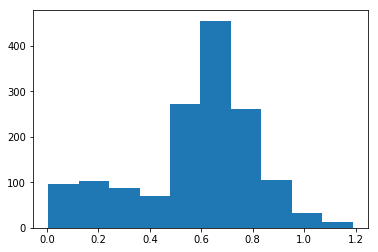

In [4]:
plt.figure()
plt.hist(rt[rt>0])

In [16]:
sm_sim = cmdstanpy.CmdStanModel(stan_file='hazard_sampling.stan')

# Generate data using prior for prior-predictive check
#sm_sim = pystan.StanModel(file='hazard_sampling.stan')

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: C:/Users/Le/DROPBO~3/Sur/Tudor/marmoset/hazard_sampling.exe


In [17]:
sm_sim.sample?

In [18]:
samples = sm_sim.sample(data={'N': len(rt_filt), 'mu0': 1.5, 'stimdur': sd_filt, 'xprev': xprev_filt}, output_dir='./', 
                        fixed_param=True, iter_sampling=1000, show_progress='notebook')

In [ ]:
samples = az.from_cmdstanpy(samples)

In [ ]:
bokeh.io.show(
    bokeh_catplot.ecdf(
        samples.posterior['lambda'].values.ravel()
    )
)

In [ ]:
# Generate data using prior for prior-predictive check
#sm_sim = pystan.StanModel(file='hazard_sampling.stan')

# Generate quantities from prior
#R = 1000 # 100 trials

#sim_data = sm_sim.sampling(data={'N': len(rt_filt), 'mu0': 1.5, 'stimdur': sd_filt, 'xprev': xprev_filt},
#                     iter=R, warmup=0, chains=1, seed=4838284, algorithm="Fixed_param")

In [ ]:
# save it to the file 'model.pkl' for later use
#with open('hazard_sampling.pkl', 'wb') as f:
#    pickle.dump(sm_sim, f)

In [ ]:
xc = sim_data.extract()['xc']
hazard = sim_data.extract()['hazard']
hazard_num = sim_data.extract()['hazard_numerator']
hazard_den = sim_data.extract()['hazard_denominator']
rmean = sim_data.extract()['rmean']
rtime = sim_data.extract()['r']


In [ ]:
plt.figure()
for i in range(rtime.shape[1]):
    rtSingleTrial = rtime[:,i]
    rtSingleTrial = rtSingleTrial[~np.isnan(rtSingleTrial)]
    # Cumulative distribution
    plt.plot(np.sort(rtSingleTrial), np.arange(len(rtSingleTrial)) / len(rtSingleTrial), 'b', alpha=0.1)
    
plt.plot(np.sort(rt_filt), np.arange(len(rt_filt)) / len(rt_filt), 'r')
plt.xlim(-5, 5)

In [20]:
#sm_inf = pystan.StanModel(file='hazard_inference.stan')
sm_inf = cmdstanpy.CmdStanModel(stan_file='hazard_inference.stan')

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: C:/Users/Le/DROPBO~3/Sur/Tudor/marmoset/hazard_inference.exe


In [ ]:
inf_data = sm_inf.sample(data={'N': len(rt_filt), 'mu0': 1.5, 'stimdur': sd_filt, 'xprev': xprev_filt, 'rt': rt_filt},
                     iter_sampling=1000, iter_warmup=200, chains=4, show_progress='notebook')

In [9]:
sigx_samples = inf_data.extract()['sigma_x']
sigr_samples = inf_data.extract()['sigma_r']
lambda_samples = inf_data.extract()['lambda']
m_samples = inf_data.extract()['m']
c_samples = inf_data.extract()['c']

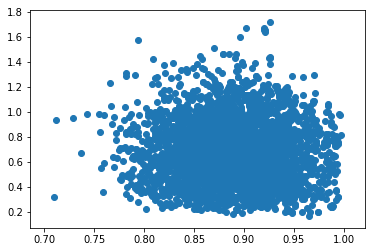

In [14]:
plt.scatter(lambda_samples, m_samples)

(array([  4.,   9.,  68., 202., 436., 699., 776., 582., 291., 133.]),
 array([0.71008946, 0.73879074, 0.76749202, 0.7961933 , 0.82489458,
        0.85359586, 0.88229714, 0.91099842, 0.93969971, 0.96840099,
        0.99710227]),
 <a list of 10 Patch objects>)

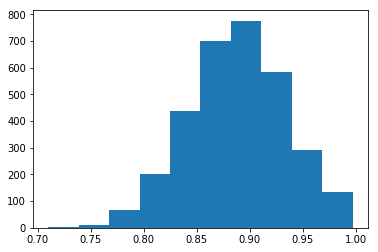

In [10]:
plt.figure()
plt.hist(lambda_samples)

In [ ]:
data['sigma_r']

In [ ]:
data['lambda']

In [13]:
transformation = lambda x: (x - np.mean(x)) / np.std(x)

bokeh.io.show(bebi103.viz.parcoord_plot(inf_data, 
                                        transformation=transformation, 
                                        pars=['lambda', 'm', 'c', 'sigma_x', 'sigma_r'],
                                       divergence_alpha=0.1, 
                                        divergence_line_width=0.5))

RuntimeError: Input must be an ArviZ InferenceData instance.

In [15]:
bebi103.stan.check_all_diagnostics(inf_data)

AttributeError: 'stanfit4anon_model_b05541c97d1b200a3b8f0bf66ec0dec' object has no attribute 'posterior'